In [1]:
import os

import librosa
import logging
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal
import re

import pickle

from scipy.io import wavfile
import tensorflow as tf
import matplotlib.pyplot as plt

# Input files

In [2]:
# Load the train dataset
train_df = pd.read_pickle('../train_physionet_2016.pkl')
val_df = pd.read_pickle('../validation_physionet_2016.pkl')
#test_df = pd.read_pickle('../test_physionet_2016.pkl')

# Convert the loaded DataFrame to the desired numpy format
train_data = []
for index, row in train_df.iterrows():
    patient_id = row['Patient ID']
    homomorphic = row['Homomorphic']
    cwt_morl = row['CWT_Morl']
    cwt_mexh = row['CWT_Mexh']
    hilbert_env = row['Hilbert_Env']
    labels = row['Labels']

    # Append each patient's data as a tuple to the train_data list
    train_data.append([patient_id, homomorphic, cwt_morl, cwt_mexh, hilbert_env, labels])

val_data = []
for index, row in val_df.iterrows():
    patient_id = row['Patient ID']
    homomorphic = row['Homomorphic']
    cwt_morl = row['CWT_Morl']
    cwt_mexh = row['CWT_Mexh']
    hilbert_env = row['Hilbert_Env']
    labels = row['Labels']

    # Append each patient's data as a tuple to the train_data list
    val_data.append([patient_id, homomorphic, cwt_morl, cwt_mexh, hilbert_env, labels])

""" test_data = []
for index, row in val_df.iterrows():
    patient_id = row['Patient ID']
    homomorphic = row['Homomorphic']
    cwt_morl = row['CWT_Morl']
    cwt_mexh = row['CWT_Mexh']
    hilbert_env = row['Hilbert_Env']
    labels = row['Labels']

    # Append each patient's data as a tuple to the train_data list
    test_data.append([patient_id, homomorphic, cwt_morl, cwt_mexh, hilbert_env, labels]) """

# Convert train_data to a numpy array with dtype=object to handle mixed types
train = np.array(train_data, dtype=object)
val = np.array(val_data, dtype=object)
#test = np.array(test_data, dtype=object)

## Filtering Smaller than patch

In [3]:
def filter_smaller_than_patch(features, patch_size):
    # Remove sounds shorter than patch size and return their indices
    return np.array([j for j in range(len(features)) if len(features[j]) >= patch_size], dtype=int)

patch_size = 64
nch = 4
stride = 8

# Ensure indices are integers and apply them correctly to filter the datasets
train_indices = filter_smaller_than_patch(train[:,2], patch_size)
val_indices = filter_smaller_than_patch(val[:,2], patch_size)
#test_indices = filter_smaller_than_patch(test[:,2], patch_size)

train = train[train_indices, ...]
val = val[val_indices, ...]
#test = test[test_indices, ...]

## Compute Patches

In [4]:
class PCGDataPreparer:
    def __init__(self, patch_size: int , stride: int, number_channels: int=4, num_states: int=4):
        self.patch_size = patch_size
        self.stride = stride
        self.number_channels = number_channels
        self.num_states = num_states
        self.features = None
        self.labels = None

    def _compute_pcg_patches(self, sound, label):
        #TODO: ask them to implement this
        num_samples = len(sound)
        # TODO: they should complete this for
        num_windows = int((num_samples - self.patch_size) / self.stride) + 1
        for window_idx in range(num_windows):
            patch_start = window_idx * self.stride
            yield sound[patch_start:patch_start + self.patch_size, :],  label[patch_start: patch_start + self.patch_size, :]

        window_remain = num_samples - self.patch_size
        if window_remain % self.stride > 0:
          yield sound[window_remain:, :], label[window_remain:, :]

    def set_features_and_labels(self, features, labels):
        self.features = features
        self.labels = labels
        num_observations = len(self.features)
        total_windows = 0
        for obs in features:
          num_samples = len(features)
          num_windows = int((num_samples - self.patch_size) / self.stride) + 1
          window_remain = num_samples - self.patch_size
          if window_remain % self.stride > 0:
              num_windows += 1
          total_windows += num_windows
        self.num_steps = total_windows

    def __call__(self):
        num_observations = len(self.labels)
        for obs_idx in range(num_observations):
            features = tf.stack(self.features[obs_idx], axis=1) # np.column_stack
            labels = self.labels[obs_idx]
            for s,y in (self._compute_pcg_patches(features, labels)):
              yield s, y

### Instantiate the Data Preparers

In [5]:
patch_size = 64
nch = 4
stride = 8
train_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
train_dp.set_features_and_labels(train[:, [1,2,3,4]], train[:, 5])

val_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
val_dp.set_features_and_labels(val[:, [1,2,3,4]], val[:, 5])

""" test_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
test_dp.set_features_and_labels(test[:, [1,2,3,4]], test[:, 5]) """

' test_dp = PCGDataPreparer(patch_size=patch_size,\n                     number_channels=nch,\n                     stride=stride,\n                     num_states=4)\ntest_dp.set_features_and_labels(test[:, [1,2,3,4]], test[:, 5]) '

### Tensorflow Dataset and caching

In [6]:
BATCH_SIZE = 8

def get_data_from_generator(*, data_processor, batch_size, patch_size, number_channels, number_classes, trainable=True):
    data = tf.data.Dataset.from_generator(data_processor,
                                          output_signature=(
                                              tf.TensorSpec(shape=(patch_size, number_channels), dtype=tf.float32),
                                              tf.TensorSpec(shape=(patch_size, number_classes), dtype=tf.float32))
                                          )
    if trainable:
        data = data.shuffle(5000, reshuffle_each_iteration=True)
        data.cache()
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

train_dataset = get_data_from_generator(data_processor=train_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=True)


val_dataset = get_data_from_generator(data_processor=val_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=False)

""" test_dataset = get_data_from_generator(data_processor=test_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=False) """

' test_dataset = get_data_from_generator(data_processor=test_dp,\n                                                batch_size=BATCH_SIZE,\n                                                patch_size=patch_size,\n                                                number_channels=nch,\n                                                number_classes=4,\n                                                trainable=False) '

# Training Pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, concatenate

# TODO: provide u-net with one encoder layer only and suggest for them to
# increase its size.
def unet_pcg(nch, patch_size, dropout=0.0):
    inputs = tf.keras.layers.Input(shape=(patch_size, nch))
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    pool1 = tf.keras.layers.Dropout(dropout)(pool1)

    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    pool2 = tf.keras.layers.Dropout(dropout)(pool2)

    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
    pool3 = tf.keras.layers.Dropout(dropout)(pool3)

    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv4)
    pool4 = tf.keras.layers.Dropout(dropout)(pool4)

    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv5)

    up6_prep = tf.keras.layers.UpSampling1D(size=2)(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up6_prep), conv4], axis=2)
    up6 = tf.keras.layers.Dropout(dropout)(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv6)

    up7_prep = tf.keras.layers.UpSampling1D(size=2)(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up7_prep), conv3], axis=2)
    up7 = tf.keras.layers.Dropout(dropout)(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv7)

    up8_prep = tf.keras.layers.UpSampling1D(size=2)(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(32, 2, padding='same')(up8_prep), conv2], axis=2)
    up8 = tf.keras.layers.Dropout(dropout)(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv8)

    up9_prep = tf.keras.layers.UpSampling1D(size=2)(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(8, 2, padding='same')(up9_prep), conv1], axis=2)
    up9 = tf.keras.layers.Dropout(dropout)(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='tanh', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv1D(4, 1, activation='softmax')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

## Hyperparameter Setting

In [8]:
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
checkpoint_path = '../pcg_unet_weights/checkpoint.keras'

In [10]:
# tune hyperpararmeter, epochs, e optimizer
# choose adequate metrics
# loss crossentropy, others?
EPOCHS = 15
learning_rate = 1e-4
model = unet_pcg(nch, patch_size)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                  metrics=['CategoricalAccuracy', 'Precision', 'Recall'])


In [11]:
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    # steps_per_epoch = int(np.floor(train_dp.num_steps / BATCH_SIZE)),
                    verbose=1,
                    shuffle=True, callbacks=[model_checkpoint])

Epoch 1/15
8092/8092 [==============================] - 712s 88ms/step - loss: 0.4754 - categorical_accuracy: 0.8389 - precision: 0.8837 - recall: 0.7903 - val_loss: 0.3539 - val_categorical_accuracy: 0.8807 - val_precision: 0.8985 - val_recall: 0.8614
Epoch 2/15
8092/8092 [==============================] - 676s 83ms/step - loss: 0.3321 - categorical_accuracy: 0.8896 - precision: 0.9043 - recall: 0.8755 - val_loss: 0.3291 - val_categorical_accuracy: 0.8893 - val_precision: 0.9041 - val_recall: 0.8737
Epoch 3/15
8092/8092 [==============================] - 704s 87ms/step - loss: 0.3098 - categorical_accuracy: 0.8968 - precision: 0.9100 - recall: 0.8845 - val_loss: 0.3194 - val_categorical_accuracy: 0.8920 - val_precision: 0.9056 - val_recall: 0.8785
Epoch 4/15
8092/8092 [==============================] - 682s 84ms/step - loss: 0.2979 - categorical_accuracy: 0.9006 - precision: 0.9133 - recall: 0.8890 - val_loss: 0.3117 - val_categorical_accuracy: 0.8954 - val_precision: 0.9086 - val_rec

In [12]:
model.load_weights(checkpoint_path)

## Inference pipeline
Collect the predictions of the U-Net

In [13]:
predictions_train = model.predict(train_dataset)
val_test = model.predict(val_dataset)

1984/1984 [==============================] - 9s 5ms/step


## Post processing

In [14]:
def process_unet_predictions(preds, dataframe, dataset, patch_size, stride):  #TODO: might be this
  num_observations = len(dataframe)
  output_probs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  output_seqs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  preds_idx = 0
  for idx, sample in enumerate(dataframe):
    sound = sample[2]
    sound_duration = len(sound)
    # number of patches associated to this sound
    number_patches = int((sound_duration - patch_size) / stride)
    if (sound_duration - patch_size) % stride > 0:
      number_patches += 1
    prob_sound = np.zeros((number_patches, sound_duration, 4))
    for i in range(number_patches):
      prob_sound[i, i * stride:i * stride + patch_size, :] = preds[preds_idx, :, :]
      preds_idx += 1
    if (sound_duration - patch_size) % stride > 0:
      prob_sound[number_patches - 1, sound_duration - patch_size:, :] = preds[preds_idx, :, :]
      preds_idx +=1

    probs_patch = tf.reduce_sum(prob_sound, axis=0)
    probs_patch_normalized = probs_patch /  (tf.reduce_sum(prob_sound, axis=[0,2])[:, tf.newaxis] + 1e-12)
    output_probs[idx] = probs_patch_normalized
    output_seqs[idx] = tf.argmax(probs_patch_normalized, axis=1)
  return output_probs, output_seqs


probs, predictions = process_unet_predictions(val_test, val, val_dataset, patch_size, stride)

## Temporal sequencing

In [15]:
def max_temporal_modelling(seq, num_states=4):
  for t in range(1, len(seq)):
    if seq[t] != seq[t-1] and seq[t] != ((seq[t-1] + 1) % num_states):
      seq[t] = seq[t-1]
  return seq

test_seq = np.array([1, 1, 1, 2, 1, 2, 2, 3, 3, 0, 3])
exp_seq = np.array([1, 1, 1, 2, 2, 2, 2, 3, 3, 0, 0])

max_temporal_modelling(test_seq)
assert np.all(exp_seq == test_seq)

# Evaluation - metrics Schmidt

In [16]:
ground_truth = np.array([np.argmax(y, axis=1) for y in val[:, -1]], dtype=object)
predictions = np.array([max_temporal_modelling(prediction.numpy()) for prediction in predictions], dtype=object)

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score
def extract_state_runs(labels, desired_states):
    """
    Extract continuous runs of the desired states from labels.

    Args:
        labels: numpy array of labels.
        desired_states: set of desired state values.

    Returns:
        A list of dictionaries with keys:
            'start': start index of the run
            'end': end index of the run (inclusive)
            'midpoint': midpoint index of the run
            'state': the state value (0 or 2)
    """
    # Ensure labels is a 1D array
    labels = np.asarray(labels).flatten()

    runs = []
    N = len(labels)
    in_run = False
    run_start = 0
    run_state = None

    for i in range(N):
        label_i = labels[i]
        # If label_i is an array (e.g., from a structured array), extract scalar
        if isinstance(label_i, np.ndarray):
            label_i = label_i.item()
        if label_i in desired_states:
            if not in_run:
                # Start of a new run
                in_run = True
                run_start = i
                run_state = label_i
        else:
            if in_run:
                # End of the run
                run_end = i - 1
                midpoint = (run_start + run_end) // 2
                runs.append({
                    'start': run_start,
                    'end': run_end,
                    'midpoint': midpoint,
                    'state': run_state
                })
                in_run = False
                run_state = None
    # Check if we're still in a run at the end
    if in_run:
        run_end = N - 1
        midpoint = (run_start + run_end) // 2
        runs.append({
            'start': run_start,
            'end': run_end,
            'midpoint': midpoint,
            'state': run_state
        })
    return runs

def compute_ppv_sensitivity(ground_truth, predictions, sample_rate, threshold=60e-3):
    """
    Compute PPV and sensitivity for states 0 and 2.

    Args:
        ground_truth: numpy array of ground truth labels.
        predictions: numpy array of predicted labels.
        sample_rate: sampling rate in Hz.

    Returns:
        ppv: Positive Predictive Value.
        sensitivity: Sensitivity (Recall).
    """
    # Ensure ground_truth and predictions are 1D arrays
    ground_truth = np.asarray(ground_truth).flatten()
    predictions = np.asarray(predictions).flatten()

    # Desired states
    desired_states = {0, 2}

    # Maximum distance in samples (treshold in seconds vs fs)
    max_distance_samples = int(threshold * sample_rate)

    # Extract runs from ground truth and predictions
    gt_runs = extract_state_runs(ground_truth, desired_states)
    pred_runs = extract_state_runs(predictions, desired_states)

    # Get midpoints and states
    gt_midpoints = np.array([run['midpoint'] for run in gt_runs])
    gt_states = np.array([run['state'] for run in gt_runs])

    pred_midpoints = np.array([run['midpoint'] for run in pred_runs])
    pred_states = np.array([run['state'] for run in pred_runs])

    # Initialize matches
    matched_gt_indices = set()
    matched_pred_indices = set()

    # Build potential matches
    potential_matches = []
    for i, (p_mid, p_state) in enumerate(zip(pred_midpoints, pred_states)):
        for j, (gt_mid, gt_state) in enumerate(zip(gt_midpoints, gt_states)):
            if gt_state == p_state:
                distance = abs(p_mid - gt_mid)
                if distance <= max_distance_samples:
                    potential_matches.append((i, j, distance))

    # Sort potential matches by distance
    potential_matches.sort(key=lambda x: x[2])

    # Perform matching
    TP = 0
    for i, j, d in potential_matches:
        if i not in matched_pred_indices and j not in matched_gt_indices:
            matched_pred_indices.add(i)
            matched_gt_indices.add(j)
            TP += 1

    # Compute FP and FN
    total_pred = len(pred_midpoints)
    total_gt = len(gt_midpoints)
    FP = total_pred - len(matched_pred_indices)
    FN = total_gt - len(matched_gt_indices)

    # Compute PPV and Sensitivity
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    return ppv, sensitivity

# Example usage:
# Assuming you have numpy arrays `ground_truth_labels` and `predicted_labels`, and `sample_rate`.

# ground_truth_labels = np.array([...])  # Your ground truth labels
# predicted_labels = np.array([...])     # Your predicted labels
# sample_rate = 1000  # Example sample rate in Hz


def compute_schmidt_metrics(ground_truth, sequences, sample_rate):
  ppvs, sensitivities, accuracies = [], [], []
  for i in range(len(ground_truth)):
    ppv, sensitivity = compute_ppv_sensitivity(ground_truth[i],
                                               sequences[i],
                                               50)
    ppvs.append(ppv)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy_score(ground_truth[i], sequences[i]))
  return np.array(ppvs), np.array(sensitivities), np.array(accuracies)


ppv, sens, acc = compute_schmidt_metrics(ground_truth, predictions, 50)

## Inspect Results

In [18]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(ground_truth, seqs, idx):

  # Define the window width in terms of seconds and convert to the corresponding sample range
  window_duration = 0.1  # 0.06 ms in seconds
  sample_interval = 1 / 50  # Time per sample in seconds (20 ms per sample at 50 Hz)

  # Calculate the equivalent width in terms of sample indices (will be <1)
  window_width_samples = window_duration / sample_interval

  # Create the plot
  plt.figure(figsize=(24, 6))

  # Plot ground truth and predictions with discrete markers and dotted lines
  plt.plot(ground_truth[idx], 'o--', label='Ground Truth', markersize=6)
  plt.plot(seqs[idx], 'o--', color='red', label='Predictions', markersize=6)


  # Set labels and legend
  plt.title(f'Signal at idx {idx} with 0.06 ms reference window')
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()

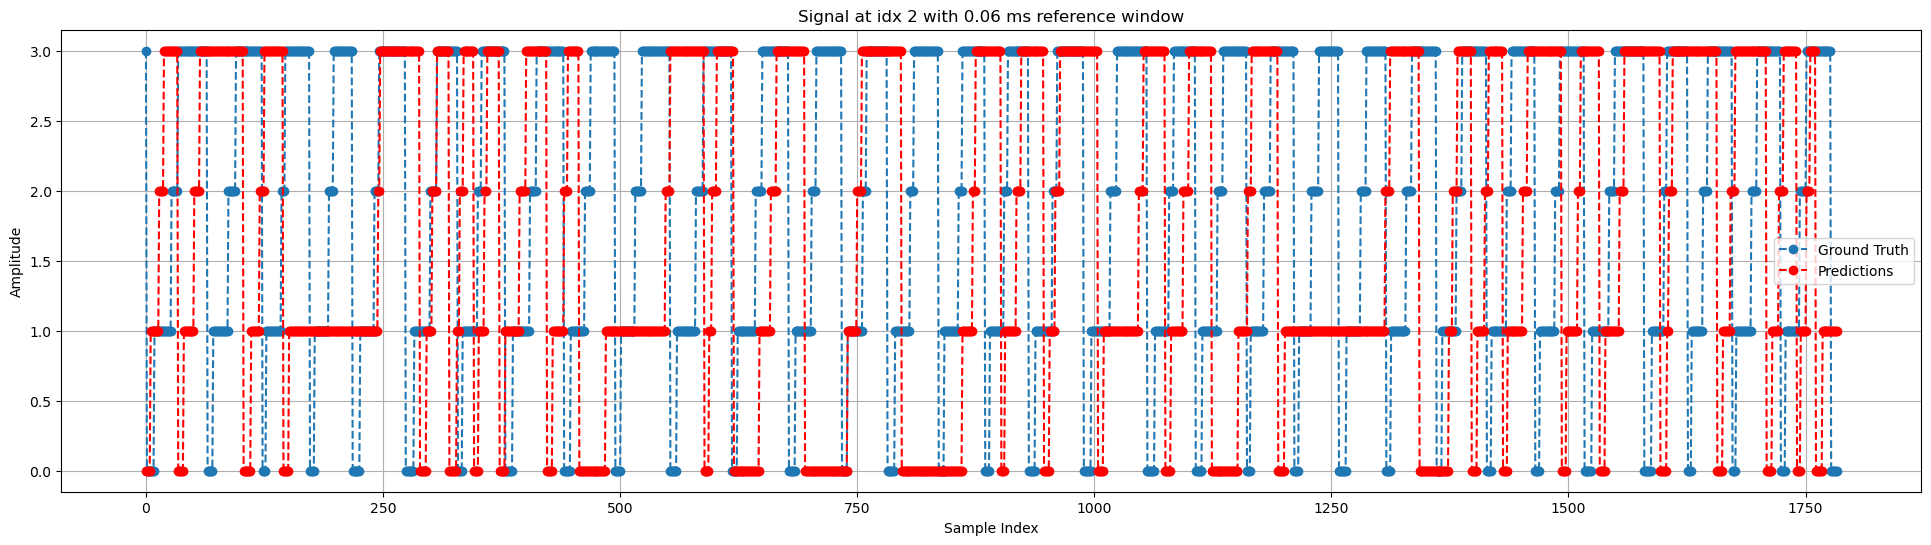

(0.06779661016949153, 0.05970149253731343, 0.24719730941704035)

In [19]:
idx = 2
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

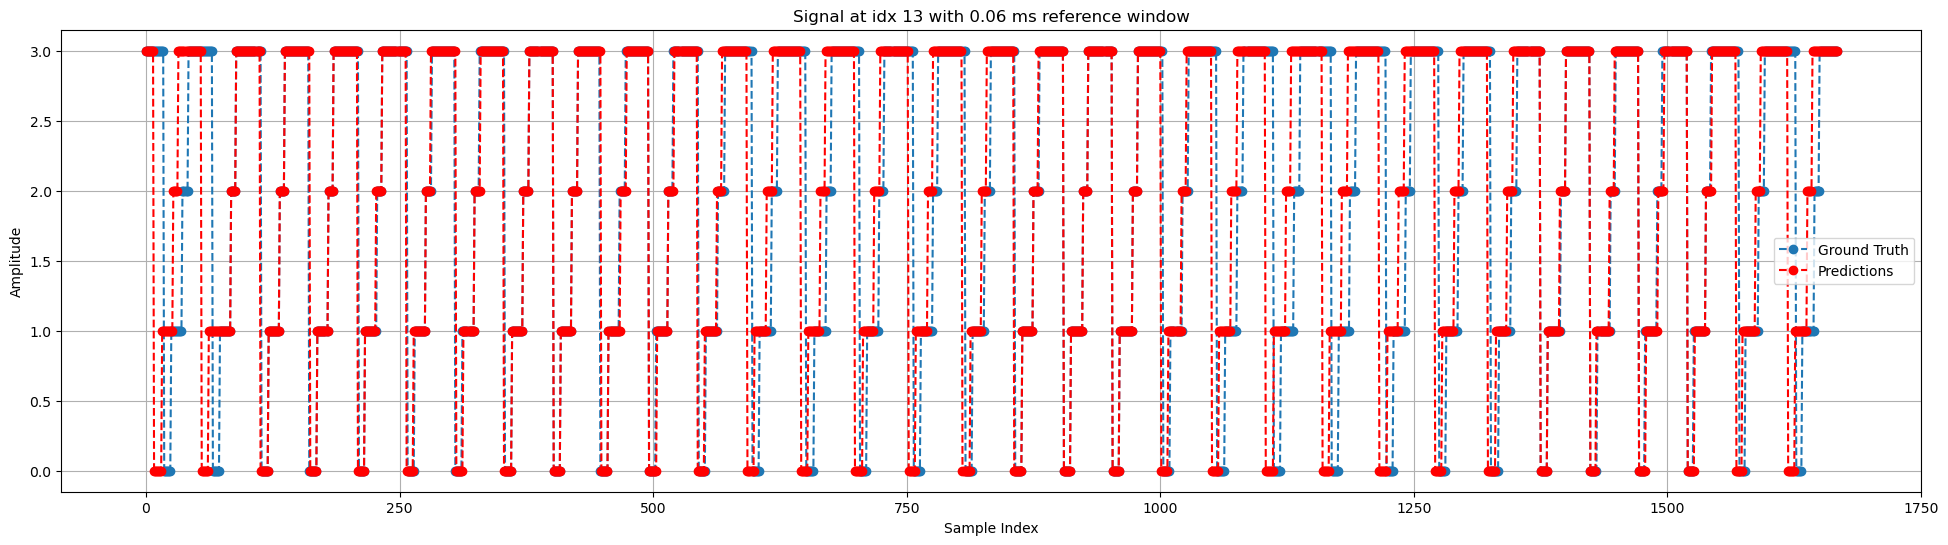

(0.6363636363636364, 0.6363636363636364, 0.7847721822541966)

In [20]:
idx = 13
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

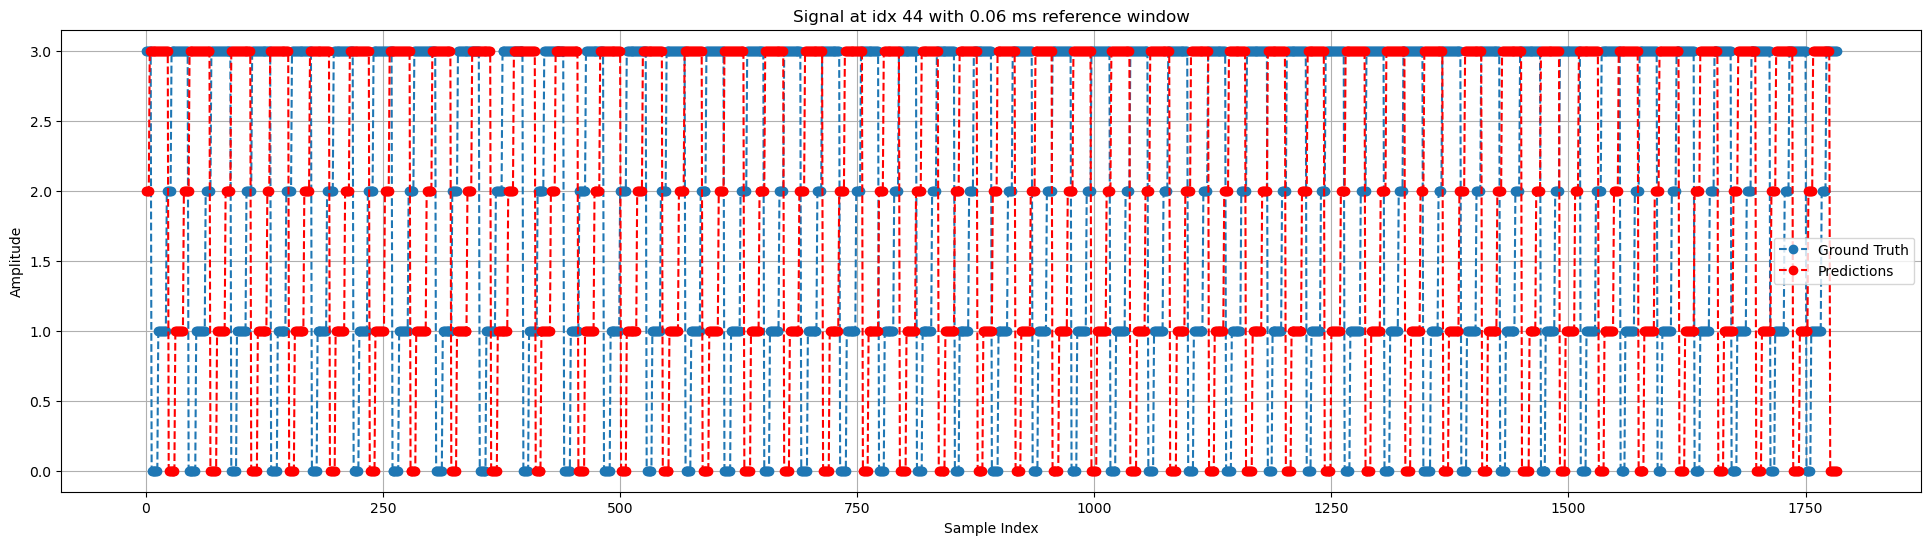

(0.0, 0.0, 0.05493273542600897)

In [21]:
idx = 44
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

## Histogram of metrics

Text(0, 0.5, 'Count')

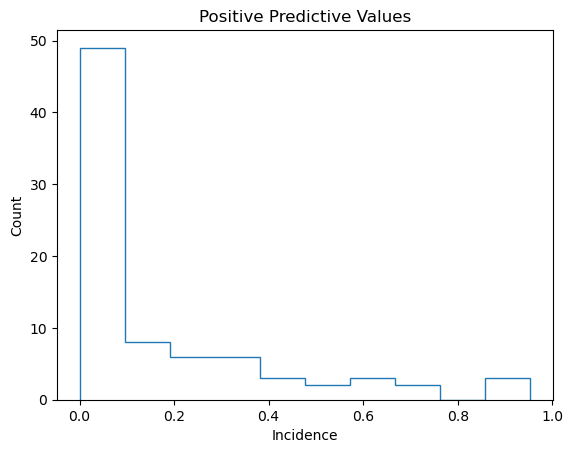

In [22]:
counts, bins = np.histogram(ppv)
plt.stairs(counts, bins)
plt.title('Positive Predictive Values')
plt.xlabel('Incidence')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

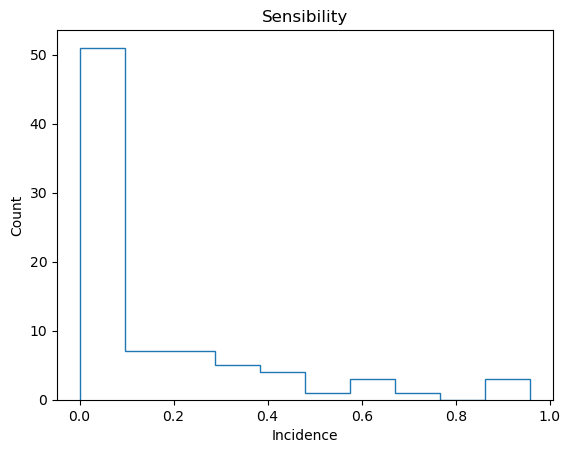

In [23]:
counts, bins = np.histogram(sens)
plt.stairs(counts, bins)
plt.title('Sensibility')
plt.xlabel('Incidence')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

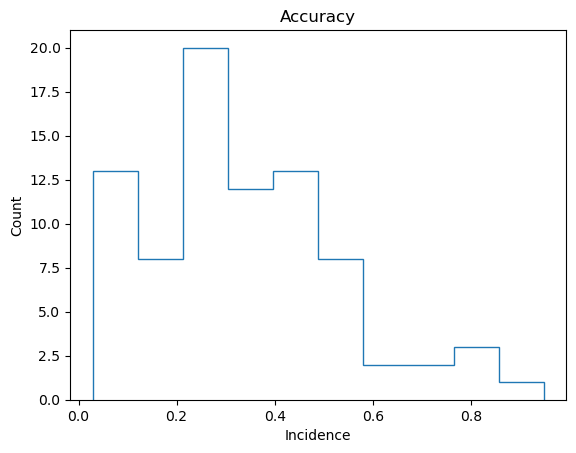

In [24]:
counts, bins = np.histogram(acc)
plt.stairs(counts, bins)
plt.title('Accuracy')
plt.xlabel('Incidence')
plt.ylabel('Count')